<a href="https://colab.research.google.com/github/KatBotkowska/Pandas-Numpy-exercices/blob/master/gsm_umts_lte_cdma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import glob
import os
import re

In [2]:
#podłączenie google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#Nie odpalać, już załadowane 
#!unzip '/content/gdrive/MyDrive/CodersCrew/wykazy_pozwolen_gsm_umts_lte_cdma.zip' -d '/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma'

Archive:  /content/gdrive/MyDrive/CodersCrew/wykazy_pozwolen_gsm_umts_lte_cdma.zip
replace /content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/UMTS2100 - stan na 2022-02-25.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
files = glob.glob(f"/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/*.xlsx")

In [3]:
files = glob.glob(f"/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/*.xlsx")
for file in files:
    title = os.path.splitext(os.path.basename(file))[0].split()[0]
    print(title)
    title = pd.read_excel(file)
    print(title.info())
    # print(os.path.splitext(os.path.basename(file)), os.path.dirname(file))


CDMA450
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nazwa Operatora    0 non-null      object
 1   Nr Decyzji         0 non-null      object
 2   Rodzaj decyzji     0 non-null      object
 3   Data ważności      0 non-null      object
 4   Dł geogr stacji    0 non-null      object
 5   Szer geogr stacji  0 non-null      object
 6   Miejscowość        0 non-null      object
 7   Lokalizacja        0 non-null      object
 8   IdStacji           0 non-null      object
 9   TERYT              0 non-null      object
dtypes: object(10)
memory usage: 0.0+ bytes
None
5G2100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9893 entries, 0 to 9892
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Nazwa Operatora    9893 non-null   object        
 1   Nr Decy

KeyboardInterrupt: ignored

In [ ]:
files = glob.glob(f"/content/gdrive/MyDrive/CodersCrew/gsm_umts_lte_cdma/*.xlsx")
def create_df(files):
    for file in files:
        title = os.path.splitext(os.path.basename(file))[0].split()[0]
        # print(title)
        title == pd.read_excel(file)
    return title
        # print(os.path.splitext(os.path.basename(file)), os.path.dirname(file))


In [5]:
def create_dict_with_df(files):
    dfs={}
    for file in files:
        title = os.path.splitext(os.path.basename(file))[0].split()[0]
        dfs[title] = pd.read_excel(file)
    return dfs

In [6]:
dfs = create_dict_with_df(files)
dfs.keys()

dict_keys(['CDMA450', '5G2100', '5G2600', 'CDMA420', '5G1800', 'GSM900', 'GSM1800', 'LTE420', 'LTE450', 'LTE800', 'LTE900', 'LTE1800', 'LTE2100', 'LTE2600', 'UMTS900', 'UMTS1800', 'UMTS2100'])

In [6]:
dfs['CDMA450'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nazwa Operatora    0 non-null      object
 1   Nr Decyzji         0 non-null      object
 2   Rodzaj decyzji     0 non-null      object
 3   Data ważności      0 non-null      object
 4   Dł geogr stacji    0 non-null      object
 5   Szer geogr stacji  0 non-null      object
 6   Miejscowość        0 non-null      object
 7   Lokalizacja        0 non-null      object
 8   IdStacji           0 non-null      object
 9   TERYT              0 non-null      object
dtypes: object(10)
memory usage: 0.0+ bytes


In [7]:
#check if all collumns are the same in each df
all([len(dfs['LTE420'].columns.intersection(df.columns)) == dfs['LTE420'].shape[1] for df in dfs.values()])

True

In [8]:
#add columns for RAT and Częstotliwość to join df
for elem in dfs.keys():
    dfs[elem].insert(0, 'RAT', ''.join([e for e in elem if not e.isdigit()] if elem[0] != '5' else "5G"))
    dfs[elem].insert(1, 'Częstotliwość', ''.join([e for e in elem[2:] if e.isdigit()]))
    

In [9]:
#concatenate all LTE's df to one
LTE_keys = [key for key in dfs.keys() if key.startswith('L')]
LTE = pd.concat([dfs[key] for key in LTE_keys])


In [10]:
LTE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95723 entries, 0 to 22632
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RAT                95723 non-null  object        
 1   Częstotliwość      95723 non-null  object        
 2   Nazwa Operatora    95723 non-null  object        
 3   Nr Decyzji         95723 non-null  object        
 4   Rodzaj decyzji     95723 non-null  object        
 5   Data ważności      95723 non-null  datetime64[ns]
 6   Dł geogr stacji    95723 non-null  object        
 7   Szer geogr stacji  95723 non-null  object        
 8   Miejscowość        95723 non-null  object        
 9   Lokalizacja        95559 non-null  object        
 10  IdStacji           95723 non-null  object        
 11  TERYT              95723 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 9.5+ MB


In [11]:
LTE.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
count,95723,95723,95723,95723,95723,95723,95723,95723,95723,95559,95723,9.572300e+04
unique,1,7,6,31140,2,129,16061,12633,7193,27229,29602,NaN
top,LTE,1800,P4 Sp. z o.o.,MNET/15/62529/12/21,zmP,2023-08-31 00:00:00,"21E01'42""","52N13'59""",Warszawa,1,LIM2006,NaN
freq,95723,29956,37030,5,75542,7397,49,107,7409,65,12,NaN
first,NaN,NaN,NaN,NaN,NaN,2022-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2032-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.738013e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.186032e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.010110e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.061011e+06


In [30]:
LTE.iloc[0]

RAT                                   LTE
Częstotliwość                         420
Nazwa Operatora      POLKOMTEL Sp. z o.o.
Nr Decyzji               MNET/8/0001/1/21
Rodzaj decyzji                          P
Data ważności         2031-01-31 00:00:00
Dł geogr stacji                 20E32'20"
Szer geogr stacji               50N43'39"
Miejscowość                        Łukowa
Lokalizacja                           189
IdStacji                          BT10182
TERYT                             2604033
Name: 0, dtype: object

In [12]:
#czy są puste komórki
LTE.isnull().sum()

RAT                    0
Częstotliwość          0
Nazwa Operatora        0
Nr Decyzji             0
Rodzaj decyzji         0
Data ważności          0
Dł geogr stacji        0
Szer geogr stacji      0
Miejscowość            0
Lokalizacja          164
IdStacji               0
TERYT                  0
dtype: int64

In [13]:
LTE['Lokalizacja']

0                              189
1                              515
2                              1\1
3                            328\1
4                              179
                   ...            
22628                            8
22629                    Miłosza 2
22630                          200
22631    Rynek Zygmunta Augusta 15
22632                     Złota 79
Name: Lokalizacja, Length: 95723, dtype: object

In [16]:
dfs['5G1800']['RAT'][0:10]

0    5G
1    5G
2    5G
3    5G
4    5G
5    5G
6    5G
7    5G
8    5G
9    5G
Name: RAT, dtype: object

zmiana gps na koordynaty geograficzne

In [16]:
dlugosc = LTE['Dł geogr stacji'][0].iloc[0]
dlugosc
szerokosc = LTE['Szer geogr stacji'][0].iloc[0]
szerokosc
# [i for i in dlugosc if i.isdigit()]

'50N43\'39"'

In [19]:
LTE['Dł geogr stacji']= [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in LTE['Dł geogr stacji']]]


In [20]:
LTE['Dł geogr stacji'] = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in LTE['Dł geogr stacji'] ]

In [21]:
LTE['Dł geogr stacji']

0        20.538889
1        20.349444
2        22.133889
3        23.125556
4        23.761944
           ...    
22628    18.845556
22629    23.177500
22630    22.993056
22631    22.977778
22632    20.995278
Name: Dł geogr stacji, Length: 95723, dtype: float64

In [22]:
LTE['Szer geogr stacji']

0        50N43'39"
1        50N28'43"
2        51N32'47"
3        51N18'42"
4        50N54'17"
           ...    
22628    51N36'16"
22629    53N07'22"
22630    53N09'43"
22631    53N50'37"
22632    52N13'45"
Name: Szer geogr stacji, Length: 95723, dtype: object

In [26]:
LTE['Szer geogr stacji']= [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in LTE['Szer geogr stacji']]]
LTE['Szer geogr stacji'] = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in LTE['Szer geogr stacji']]

In [27]:
LTE['Szer geogr stacji']

0        50.727500
1        50.478611
2        51.546389
3        51.311667
4        50.904722
           ...    
22628    51.604444
22629    53.122778
22630    53.161944
22631    53.843611
22632    52.229167
Name: Szer geogr stacji, Length: 95723, dtype: float64

In [14]:
def conversion(gps):
    gps = [re.split(r"(\d+\D+)", elem) for elem in [elem.replace('\'',' ').replace('"',' ') for elem in gps]]
    gps = [int(elem[1][:-1])+int(elem[3])/60.0 + int(elem[5])/3600.0 for elem in gps]
    return gps

In [15]:
LTE['Szer geogr stacji'] = conversion(LTE['Szer geogr stacji'])

In [16]:
LTE['Dł geogr stacji'] = conversion(LTE['Dł geogr stacji'])
LTE['Dł geogr stacji']

0        20.538889
1        20.349444
2        22.133889
3        23.125556
4        23.761944
           ...    
22628    18.845556
22629    23.177500
22630    22.993056
22631    22.977778
22632    20.995278
Name: Dł geogr stacji, Length: 95723, dtype: float64

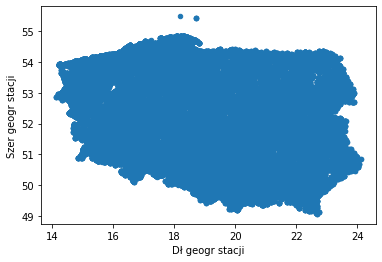

In [17]:
LTE.plot(x='Dł geogr stacji', y='Szer geogr stacji', kind="scatter", colormap="YlOrRd")

In [18]:
Wroclaw = LTE.loc[LTE['Miejscowość'] == 'Wrocław'].reset_index()
# df.loc[df['column_name'] == some_value]

In [19]:
Wroclaw

,index,RAT,Częstotliwość,Nazwa Operatora,Nr Decyzji,Rodzaj decyzji,Data ważności,Dł geogr stacji,Szer geogr stacji,Miejscowość,Lokalizacja,IdStacji,TERYT
0,221,LTE,420,POLKOMTEL Sp. z o.o.,MNET/8/0222/1/21,P,2031-01-31,16.980000,51.117500,Wrocław,ul. Bystrzycka 24,BT34103,264011
1,4061,LTE,800,Orange Polska S.A.,MNET/15/76001/10/18,zmP,2023-04-30,17.118056,51.118056,Wrocław,"Swojczycka 38, 8\66",2352,264011
2,4062,LTE,800,Orange Polska S.A.,MNET/15/76499/8/18,zmP,2024-05-31,17.042222,51.076111,Wrocław,"Świeradowska 51-57, dz. nr 66\12",14246,264011
3,4063,LTE,800,Orange Polska S.A.,MNET/15/76560/8/18,zmP,2024-04-30,16.973611,51.165278,Wrocław,dz. nr 38\2,14285,264011
4,4067,LTE,800,Orange Polska S.A.,MNET/15/77003/10/20,zmP,2023-05-31,16.992500,51.111667,Wrocław,"Fabryczna 10, 1/13",2413,264011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,22614,LTE,2600,T-Mobile Polska S.A.,MNET/2/76215/2/20,zmP,2029-12-31,17.130833,51.149722,Wrocław,Bierutowska 57/59,46215,264011
2077,22615,LTE,2600,T-Mobile Polska S.A.,MNET/2/76556/1/18,P,2028-03-31,17.028056,51.099444,Wrocław,Powstańców Śląskich 2-4,46556,264011
2078,22616,LTE,2600,T-Mobile Polska S.A.,MNET/2/76670/1/18,P,2028-03-31,16.990556,51.119167,Wrocław,Legnicka 58,46670,264011
2079,22617,LTE,2600,T-Mobile Polska S.A.,MNET/2/76671/1/18,P,2028-03-31,17.031111,51.103889,Wrocław,Świdnicka 40,46671,264011


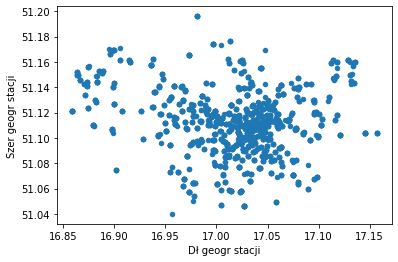

In [20]:
Wroclaw.plot(x='Dł geogr stacji', y='Szer geogr stacji', kind="scatter", colormap="YlOrRd")

In [21]:
import math
from itertools import combinations

def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x = Wroclaw['Dł geogr stacji']
y = Wroclaw['Szer geogr stacji']

points = list(zip(x,y))
distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
avg_distance = sum(distances) / len(distances)

In [25]:
from geopy.distance import distance
dist = [distance(p1,p2).km for p1, p2 in combinations(points,2)]
avg_dist = sum(dist) / len(dist)

In [26]:
avg_dist

7.7947922261017375

In [29]:
Legnica = LTE.loc[LTE['Miejscowość'] == 'Legnica'].reset_index()
Legnica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              217 non-null    int64         
 1   RAT                217 non-null    object        
 2   Częstotliwość      217 non-null    object        
 3   Nazwa Operatora    217 non-null    object        
 4   Nr Decyzji         217 non-null    object        
 5   Rodzaj decyzji     217 non-null    object        
 6   Data ważności      217 non-null    datetime64[ns]
 7   Dł geogr stacji    217 non-null    float64       
 8   Szer geogr stacji  217 non-null    float64       
 9   Miejscowość        217 non-null    object        
 10  Lokalizacja        217 non-null    object        
 11  IdStacji           217 non-null    object        
 12  TERYT              217 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usag

In [31]:
x_Legnica = Legnica['Dł geogr stacji']
y_Legnica = Legnica['Szer geogr stacji']

points_Legnica = list(zip(x_Legnica,y_Legnica))

dist = [distance(p1,p2).km for p1, p2 in combinations(points_Legnica,2)]
avg_dist_Legnica = sum(dist) / len(dist)

In [22]:
avg_distance

0.07107197285302791

In [32]:
avg_dist_Legnica

3.6086782041515204